In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import yfinance as yf

from portfolio_optimization.data import DataCollector
from portfolio_optimization.optimization import PortfolioOptimizer

# Set up plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [12, 6]  # Larger default figure size
plt.rcParams['axes.grid'] = True          # Always show grid
plt.rcParams['axes.spines.top'] = False   # Remove top spine
plt.rcParams['axes.spines.right'] = False # Remove right spine
sns.set_palette('husl')                   # Set color palette

In [2]:
# setting up ticker
ticker_symbol = '^GSPC'
ticker_name = 'S&P 500'

# Set pandas display options for better readability
pd.options.display.float_format = '{:,.2f}'.format


In [3]:
# Getting data from yahoo finance
ticker_object = yf.Ticker(ticker_symbol)

# Getting historical data
historical_data = ticker_object.history(start='2014-01-01', end='2024-12-20')

# Displaying the first 5 rows of the historical data
print(historical_data.shape)
historical_data.head()



(2761, 7)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-01-02 00:00:00-05:00,"1,845.86","1,845.86","1,827.74","1,831.98",3080600000,0.00,0.00
2014-01-03 00:00:00-05:00,"1,833.21","1,838.24","1,829.13","1,831.37",2774270000,0.00,0.00
2014-01-06 00:00:00-05:00,"1,832.31","1,837.16","1,823.73","1,826.77",3294850000,0.00,0.00
2014-01-07 00:00:00-05:00,"1,828.71","1,840.10","1,828.71","1,837.88",3511750000,0.00,0.00
2014-01-08 00:00:00-05:00,"1,837.90","1,840.02","1,831.40","1,837.49",3652140000,0.00,0.00


In [4]:
# Creating a candlestick chart with improved styling
fig = go.Figure(data=[go.Candlestick(x=historical_data.index,
                                    open=historical_data['Open'],
                                    high=historical_data['High'],
                                    low=historical_data['Low'],
                                    close=historical_data['Close'],
                                    name=ticker_name)])

# Update the layout for better visualization
fig.update_layout(
    title=f'{ticker_name} Stock Price History',
    yaxis_title='Price (USD)',
    xaxis_title='Date',
    showlegend=False,
    height=800  # Larger height for better visibility
)

# Add range slider and buttons for time period selection
fig.update_xaxes(rangeslider_visible=True,
                 rangeselector=dict(
                     buttons=list([
                         dict(count=1, label="1m", step="month", stepmode="backward"),
                         dict(count=6, label="6m", step="month", stepmode="backward"),
                         dict(count=1, label="YTD", step="year", stepmode="todate"),
                         dict(count=1, label="1y", step="year", stepmode="backward"),
                         dict(step="all")
                     ])
                 ))

fig.show()

In [5]:
# Calculate returns and create masks for positive/negative returns
historical_data['Returns'] = historical_data['Close'].pct_change()
historical_data['Returns'].dropna(inplace=True)

returns = historical_data['Returns']
pos_mask = returns >= 0
neg_mask = returns < 0

# Create figure with positive and negative return traces
fig = go.Figure([
    go.Scatter(
        x=historical_data.index[pos_mask],
        y=returns[pos_mask],
        name='Positive Returns',
        mode='lines',
        line=dict(color='#26A69A', width=2)
    ),
    go.Scatter(
        x=historical_data.index[neg_mask], 
        y=returns[neg_mask],
        name='Negative Returns',
        mode='lines',
        line=dict(color='#EF5350', width=2)
    )
])

# Update layout
fig.update_layout(
    title='Returns of the S&P 500',
    xaxis_title='Date',
    yaxis_title='Return',
    showlegend=True,
    height=600
)

# Add range slider and buttons
fig.update_xaxes(rangeslider_visible=True,
                 rangeselector=dict(
                     buttons=list([
                         dict(count=1, label="1m", step="month", stepmode="backward"),
                         dict(count=6, label="6m", step="month", stepmode="backward"),
                         dict(count=1, label="YTD", step="year", stepmode="todate"),
                         dict(count=1, label="1y", step="year", stepmode="backward"),
                         dict(step="all")
                     ])
                 ))

fig.show()


In [6]:
# What has been the annualized return of the S&P 500?
annualized_return = historical_data['Returns'].mean() * 252
print(f"The annualized return of the S&P 500 is {annualized_return*100:.2f}%")

# What has been the annualized volatility of the S&P 500?
annualized_volatility = historical_data['Returns'].std() * np.sqrt(252)
print(f"The annualized volatility of the S&P 500 is {annualized_volatility*100:.2f}%")

# What has been the annualized Sharpe ratio of the S&P 500?
risk_free_rate = yf.Ticker('^TNX').history()['Close'].iloc[-1]/100
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
print(f"The annualized Sharpe ratio of the S&P 500 is {sharpe_ratio:.2f}")


The annualized return of the S&P 500 is 12.14%
The annualized volatility of the S&P 500 is 17.34%
The annualized Sharpe ratio of the S&P 500 is 0.44


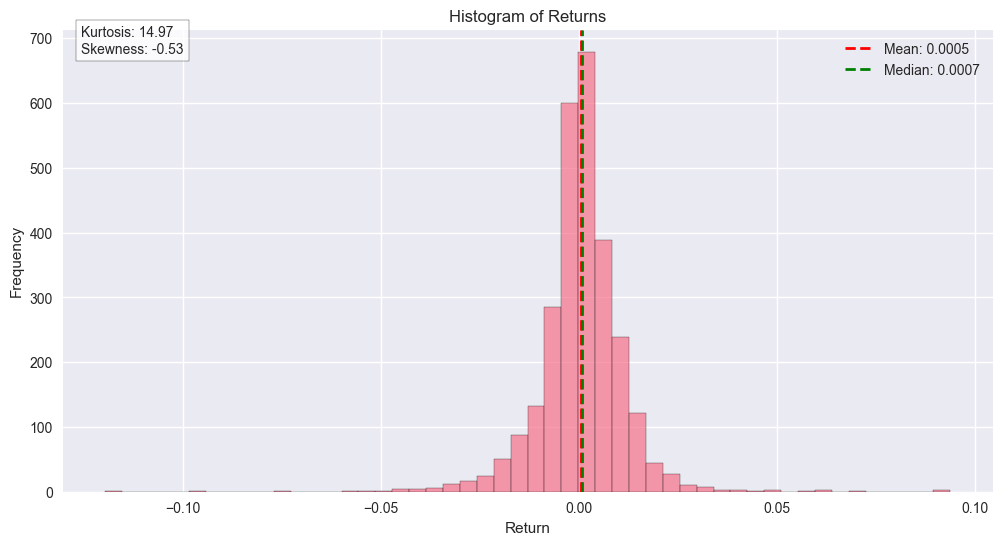

In [12]:
# Histogram of returns
plt.hist(historical_data['Returns'], bins=50, edgecolor='black', alpha=0.7)

# Calculate statistics
mean_return = historical_data['Returns'].mean()
median_return = historical_data['Returns'].median()
kurtosis = historical_data['Returns'].kurtosis()
skewness = historical_data['Returns'].skew()

# Add vertical lines for mean, median, mode
plt.axvline(mean_return, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_return:.4f}')
plt.axvline(median_return, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_return:.4f}')

plt.title('Histogram of Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.text(0.02, 0.95, f'Kurtosis: {kurtosis:.2f}\nSkewness: {skewness:.2f}', 
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))
plt.legend()
plt.show()

In [14]:
# plotting the SMA and close price
historical_data['SMA_7'] = historical_data['Close'].rolling(window=7).mean()
historical_data['SMA_30'] = historical_data['Close'].rolling(window=30).mean()
historical_data['SMA_90'] = historical_data['Close'].rolling(window=90).mean()
historical_data['SMA_180'] = historical_data['Close'].rolling(window=180).mean()
historical_data['SMA_365'] = historical_data['Close'].rolling(window=365).mean()

# Create figure using plotly
fig = go.Figure()

# Add traces for Close Price and SMA
fig.add_trace(
    go.Scatter(
        x=historical_data.index,
        y=historical_data['Close'],
        name='Close Price',
        line=dict(color='#1f77b4', width=1.5)
    )
)

fig.add_trace(
    go.Scatter(
        x=historical_data.index,
        y=historical_data['SMA_30'],
        name='30-Day SMA',
        line=dict(color='#ff7f0e', width=2)
    )
)

# Update layout
fig.update_layout(
    title='S&P 500 Close Price vs 30-Day Simple Moving Average',
    title_x=0.5,
    xaxis_title='Date',
    yaxis_title='Price ($)',
    template='plotly_white',
    hovermode='x unified',
    showlegend=True,
    height=600,
    width=1200,
    xaxis=dict(
        rangeslider=dict(visible=True),
        type='date'
    )
)

fig.show()
